# Elo Merchant

## Introduction
This notebook represents Sean Ng's submission to elo merchant. 

I got some feature engineering ideas from:

https://www.kaggle.com/denzo123/a-closer-look-at-date-variables


## Helper functions to manage memory

In [610]:
import gc
gc.collect()

653

In [611]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [612]:
#To reset all variables
def remove_var(*varnames):
    """
    varnames are what you want to keep
    """
    globals_ = globals()
    to_save = {v: globals_[v] for v in globals_ if v not in varnames }
    to_save['my_reset'] = my_reset  # lets keep this function by default
    del globals_
    get_ipython().magic("reset")
    globals().update(to_save)

In [613]:
def find_variables():
    import sys

    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [614]:
## Importing data

In [615]:
#Declaring imports
import csv
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgd


In [616]:
EXPLORE = False

In [617]:
#Files
train_data_path = '../input/train.csv'
test_data_path = '../input/test.csv'
history_path = '../input/historical_transactions.csv'
merchant_path = '../input/merchants.csv'
new_transactions_path = '../input/new_merchant_transactions.csv'


In [618]:
train_df = reduce_mem_usage(pd.read_csv(train_data_path, parse_dates=["first_active_month"]))
test_df = reduce_mem_usage(pd.read_csv(test_data_path, parse_dates=["first_active_month"]))
n_train = train_df.shape[0]


Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [619]:
merchants = pd.read_csv(merchant_path)

In [620]:
all_transactions = reduce_mem_usage(
    pd.read_csv(new_transactions_path, parse_dates=["purchase_date"])
    .append(
        pd.read_csv(history_path, parse_dates=["purchase_date"]),
        ignore_index=True
    )
)

Mem. usage decreased to 1867.06 Mb (43.7% reduction)


In [621]:
n_new_transactions = pd.read_csv(new_transactions_path, parse_dates=["purchase_date"]).shape[0]

In [681]:
all_data = train_df.append(test_df, ignore_index=True)

/anaconda/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Simple exploration

In [623]:
all_data.describe()

,feature_1,feature_2,feature_3,target
count,325540.00000,325540.000000,325540.000000,201917.000000
mean,3.10681,1.744038,0.565116,NaN
std,1.18728,0.750540,0.495742,0.000000
min,1.00000,1.000000,0.000000,-33.218750
25%,2.00000,1.000000,0.000000,-0.883301
50%,3.00000,2.000000,1.000000,-0.023438
75%,4.00000,2.000000,1.000000,0.765625
max,5.00000,3.000000,1.000000,17.968750


In [624]:
if EXPLORE:
    all_transactions.describe()

In [625]:
print("All data shape:" + str(all_data.shape))
print("-----------------------------------------------------")
print("Train data shape:" + str(train_df.shape))
print("Test data shape:" + str(test_df.shape))
print("=====================================================")
print("All transactions data shape:" + str(all_transactions.shape))
print("-----------------------------------------------------")
print("Old transactions data shape:" + str(history_df.shape))
print("New transactions data shape:" + str(new_transactions_df.shape))

All data shape:(325540, 6)
-----------------------------------------------------
Train data shape:(201917, 6)
Test data shape:(123623, 5)
All transactions data shape:(31075392, 14)
-----------------------------------------------------
Old transactions data shape:(29112361, 14)
New transactions data shape:(31075392, 14)


In [626]:
def get_df_name(df):
    for x in globals():
        if globals()[x] is df:
            return x

In [627]:
#Finding number of null values
def count_nulls(df_list):
    result = {}
    for df in df_list:
        vals = {}
        for key in df.keys():
            count = df[key].isnull().sum()
            if count > 0:
                vals[key] = count
        name = get_df_name(df)
        result[name] = vals
    return pd.DataFrame.from_dict(result, dtype=int)
count_nulls([all_data, all_transactions, merchants])


,all_data,all_transactions,merchants
avg_sales_lag12,NaN,NaN,13.0
avg_sales_lag3,NaN,NaN,13.0
avg_sales_lag6,NaN,NaN,13.0
category_2,NaN,2764609.0,11887.0
category_3,NaN,234081.0,NaN
first_active_month,1.0,NaN,NaN
merchant_id,NaN,164697.0,NaN
target,123623.0,NaN,NaN


# Handling Nulls

1. Viewing the distribution of non-null values

In [628]:
#putting each col into a bucket
def classify_categories(df, cols):
    discrete = []
    continuous = []
    for col in cols:
        
        length = len(df[col].unique())
        if length <= 25 :
            discrete.append(col)
        else:
            continuous.append(col)
    return discrete, continuous


In [629]:
def plot_na(df, cols):
    discrete, continuous = classify_categories(df, cols)
    all_count = len(continuous) + len(discrete)
    #Distributions of continuous dVata
    fig, axes = plt.subplots(nrows=all_count, ncols=1, figsize=(3,5*all_count))
    if all_count == 1:
        axes = [axes]
    for i, col_name in enumerate(discrete):
        df[col_name].value_counts().plot(kind='bar', ax=axes[i], title = col_name)
    for i, col_name in enumerate(continuous):
        df[col_name].plot(kind='density', ax=axes[i+len(discrete)], title = col_name)
    


In [630]:
if EXPLORE:
    plot_na(all_transactions, ["category_2", "category_3"])

In [631]:
if EXPLORE:
    plot_na(merchants, ['avg_sales_lag12','avg_sales_lag3','avg_sales_lag6','category_2'])

In [632]:
if EXPLORE:
    #Plot date to get a rough idea
    all_data.set_index(['first_active_month']).groupby('first_active_month').card_id.count().plot()

In [633]:
if EXPLORE:
    merchants.avg_sales_lag3[merchants.avg_sales_lag3!=np.nan].sort_values(ascending=False)[500:].plot()

# Looking at distribution of target value

/anaconda/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:107: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/function_base.py:133: RuntimeWarning: invalid value encountered in multiply
  y *= step
/anaconda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/function_base.py:142: RuntimeWarning: invalid value encountered in add
  y += start
/anaconda/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:87


 mu = -0.39 and sigma = 3.85



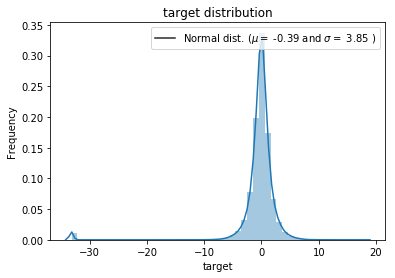

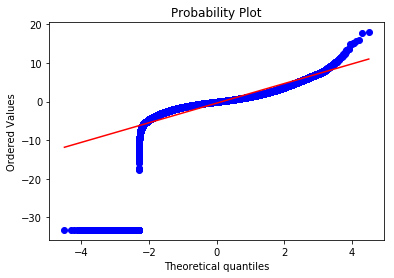

In [851]:
from scipy import stats
from scipy.stats import norm, skew
#Check the new distribution 
sns.distplot(train_df['target'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['target'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('target distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['target'], plot=plt)
plt.show()

# Feature Engineering

## Converting date to corresponding date difference

In [682]:
all_data["time_difference"] = (datetime.today() - all_data["first_active_month"]).dt.days

In [805]:
all_transactions["time_diff_transaction"] = (datetime.today() - all_transactions["purchase_date"]).dt.days

In [796]:
all_transactions["hour"] = all_transactions["purchase_date"].dt.hour

In [806]:
all_transactions["month_diff"] = all_transactions.time_diff_transaction//30

In [807]:
all_transactions["month_diff"] += all_transactions["month_lag"]

## Making the day of week relevant

In [791]:
all_transactions["day_of_week"] = all_transactions["purchase_date"].dt.weekday


In [792]:
all_transactions["weekend"] = (all_transactions["day_of_week"]>=5).astype(int)

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_amount',
       'purchase_date', 'state_id', 'subsector_id', 'category_2_1.0',
       'category_2_2.0', 'category_2_3.0', 'category_2_4.0', 'category_2_5.0',
       'category_3_A', 'category_3_B', 'category_3_C', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'time_diff_transaction',
       'day_of_week', 'weekend'],
      dtype='object')

## Seperating data by flag because apparently they have significant difference

In [638]:
flag = all_transactions["authorized_flag"].copy()

## LabelEncode/ Hot Encode the necessary values


In [639]:
from sklearn.preprocessing import LabelEncoder
def LabelEncodeCols(df, cols):
    new_df = df.copy()
    for col in cols:
        lbl = LabelEncoder()
        new_df[col] = lbl.fit_transform(new_df[col])
    return new_df



In [640]:
all_transactions = LabelEncodeCols(all_transactions, ["authorized_flag", "category_1"])

In [641]:
all_transactions = pd.get_dummies(all_transactions, columns=["category_2", "category_3", "day_of_week"])

In [642]:
all_transactions_flagged.shape

(28558483, 27)

In [643]:
all_transactions.shape

(31075392, 27)

In [812]:
#TODO: Consider if I should flag out data that is not authoized (authorized flag)
def aggregate(history):
    
    agg = {
        "authorized_flag":["mean", "var"],
        "category_1":["mean", "var", "sum"],
        "category_2_1.0":["mean"], 
        "category_2_2.0":["mean"],
        "category_2_3.0":["mean"],
        "category_2_4.0":["mean"],
        "category_2_5.0":["mean"],
        "category_3_A":["mean"],
        "category_3_B":["mean"],
        "category_3_C":["mean"],
        "city_id":['nunique'],
        "month_lag":[np.ptp, "mean"],
        "installments":["max", "mean", "var"],
        "weekend":["sum", "mean"],
        "merchant_id":['nunique'],
        "state_id":['nunique'],
        "subsector_id":["nunique"],
        "purchase_amount":["mean", "std", "min", "max"],
        "day_of_week_0":["mean"],
        "day_of_week_1":["mean"],
        "day_of_week_2":["mean"],
        "day_of_week_3":["mean"],
        "day_of_week_4":["mean"],
        "day_of_week_5":["mean"],
        "day_of_week_6":["mean"],
        "card_id":["size"],
        "time_diff_transaction":["mean", "var", "min", "max"],
        "hour":["mean", "var", "min", "max"],
        "month_diff":["mean", "var", "min", "max"],
    }
    
    new_df = history.groupby("card_id").agg(agg)
    #Replace columns
    new_df.columns = [' '.join(col).strip() for col in new_df.columns.values]
    return new_df
    

In [813]:
all_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,time_diff_transaction,day_of_week,weekend,hour,month_diff
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,...,0,0,0,0,1,297,6,1,14,10
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,...,0,0,0,0,0,289,0,0,18,10
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,...,0,1,0,0,0,252,3,0,14,10
3,1,C_ID_415bb3a509,-1,1,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,...,1,0,0,0,0,302,2,0,9,11
4,1,C_ID_ef55cf8d4b,-1,1,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,...,0,1,0,0,0,286,3,0,21,10


In [814]:
aggregate_unflagged_transactions = aggregate(all_transactions[flag=='Y'])
aggregate_flagged_transactions = aggregate(all_transactions[flag=='N'])
aggregate_new_transactions = aggregate(all_transactions[:n_new_transactions])
aggregate_old_transactions = aggregate(all_transactions[n_new_transactions:])

In [815]:
aggregate_all_transactions = aggregate(all_transactions)

In [753]:
old_all_data = all_data.copy()

In [784]:
all_data = old_all_data.copy()

In [817]:
aggregate_flagged_transactions.columns = ["flag_" + x for x in aggregate_flagged_transactions.keys()]

In [818]:
aggregate_unflagged_transactions.columns = ["unflagged_" + x for x in aggregate_unflagged_transactions.keys()]

In [819]:

aggregate_new_transactions.columns = ["new_" + x for x in aggregate_new_transactions.keys()]

In [820]:

aggregate_old_transactions.columns = ["old_" + x for x in aggregate_old_transactions.keys()]

In [821]:
print(all_data.columns.values)

['card_id' 'feature_1' 'feature_2' 'feature_3' 'first_active_month'
 'target' 'time_difference']


In [822]:
all_data = pd.merge(all_data, aggregate_unflagged_transactions, on='card_id', how='left')

In [823]:
all_data = pd.merge(all_data, aggregate_flagged_transactions, on='card_id', how='left')


In [824]:
all_data = pd.merge(all_data, aggregate_new_transactions, on='card_id', how='left')


In [825]:
all_data = pd.merge(all_data, aggregate_old_transactions, on='card_id', how='left')


In [826]:
all_data = pd.merge(all_data, aggregate_all_transactions, on='card_id', how='left')

In [827]:
#Consider adding other columns. i.e. grouping the values across time (!!!!!)

In [828]:
#tuning hyperparameters

In [829]:
#Features that others added
#Handling month_lag?

1. Month difference between today and purchase date (might be more significant than just date(?). I need to be able to convert to something significant anyway
2. Aggregation based statistics


In [830]:
months = all_data['first_active_month']
del all_data['first_active_month']

In [831]:
all_data.fillna(0, inplace=True)

# Training Phase

In [832]:
all_data = reduce_mem_usage(all_data)

Mem. usage decreased to 157.40 Mb (72.3% reduction)


In [833]:
if "target" in all_data.keys():
    target = all_data["target"][:n_train]
to_be_deleted = ["target", "card_id"]
for col in to_be_deleted:
    if col in all_data.keys():
        del all_data[col]
train = all_data[:n_train]
test = all_data[n_train:]

In [834]:
# Selecting the right features
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [842]:
import time
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
def run_lgbm_cv():
    categorical_feats = ["feature_2", "feature_3"]
    folds = KFold(n_splits = 5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()
    features = all_data.keys()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )

        num_round = 10000
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    return feature_importance_df, predictions

In [843]:
feature_importance_df, predictions = run_lgbm_cv()

fold n°0


/anaconda/envs/tensorflow/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda/envs/tensorflow/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7146	valid_1's rmse: 3.77881
[200]	training's rmse: 3.64461	valid_1's rmse: 3.73304
[300]	training's rmse: 3.59921	valid_1's rmse: 3.71087
[400]	training's rmse: 3.56562	valid_1's rmse: 3.69945
[500]	training's rmse: 3.53979	valid_1's rmse: 3.69286
[600]	training's rmse: 3.51861	valid_1's rmse: 3.68876
[700]	training's rmse: 3.5012	valid_1's rmse: 3.68571
[800]	training's rmse: 3.48514	valid_1's rmse: 3.68349
[900]	training's rmse: 3.47016	valid_1's rmse: 3.68206
[1000]	training's rmse: 3.45701	valid_1's rmse: 3.68123
[1100]	training's rmse: 3.44342	valid_1's rmse: 3.68061
[1200]	training's rmse: 3.43118	valid_1's rmse: 3.68006
[1300]	training's rmse: 3.4184	valid_1's rmse: 3.6798
[1400]	training's rmse: 3.40636	valid_1's rmse: 3.67968
[1500]	training's rmse: 3.3951	valid_1's rmse: 3.67929
[1600]	training's rmse: 3.38379	valid_1's rmse: 3.67935
[1700]	training's rmse: 3.3729	valid_1's rmse: 3.67921


/anaconda/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [848]:

feature_importances = feature_importance_df.groupby("feature").mean().sort_values(by="importance", ascending=False)

In [849]:

feature_importances = feature_importances.reset_index()


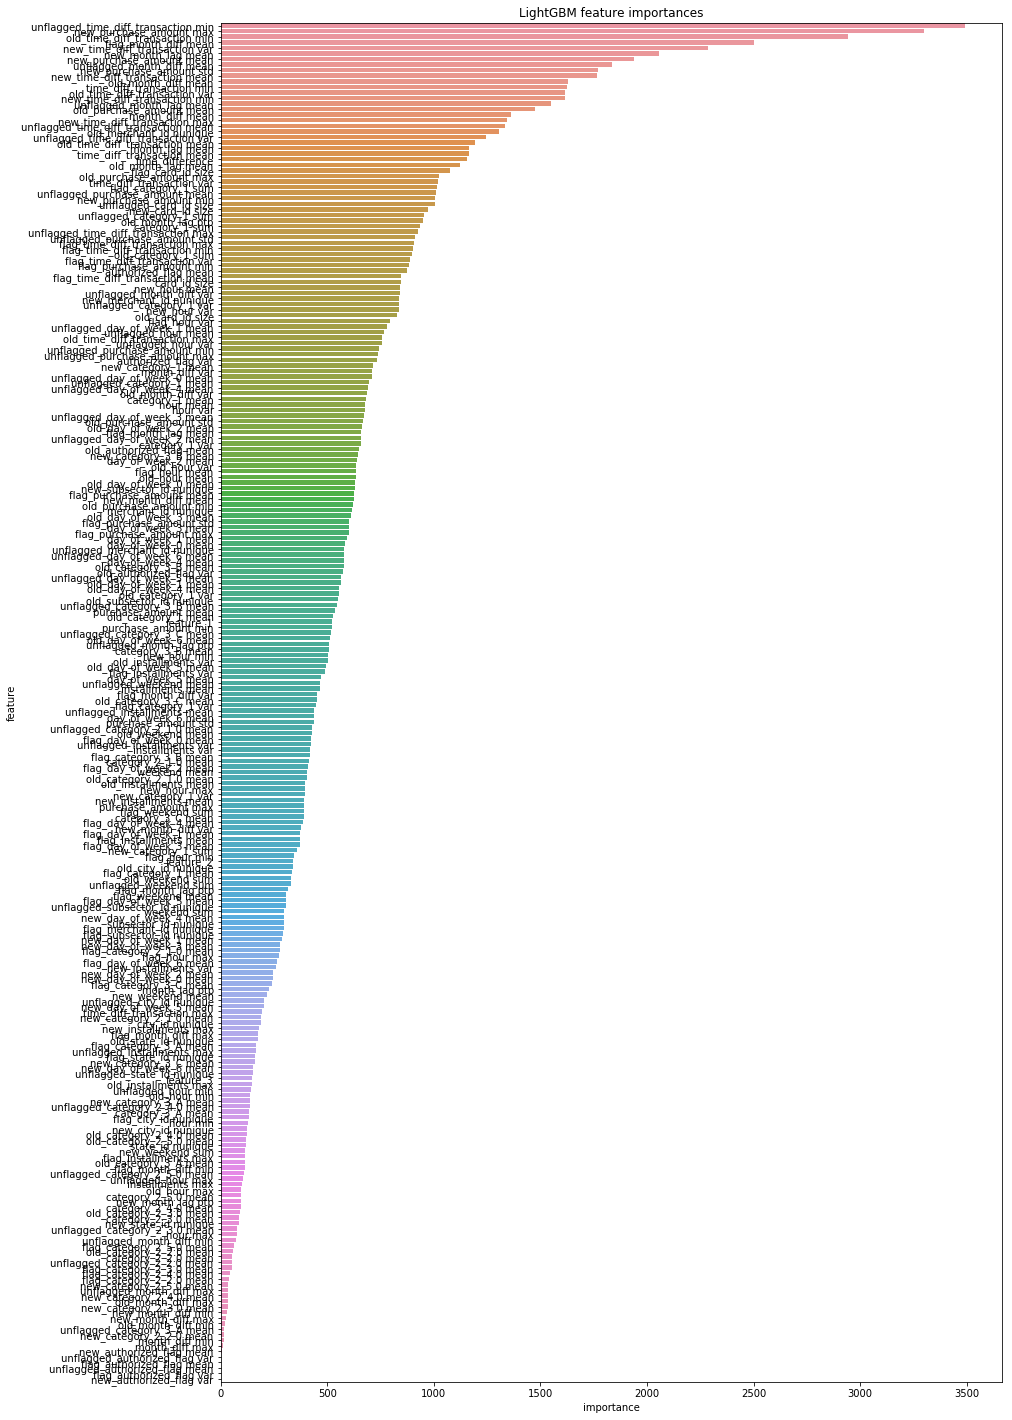

In [850]:
EXPLORE = True
if EXPLORE:
    plt.figure(figsize=(14,25))q1@wsX
    
    plt.title('LightGBM feature importances')
    sns.barplot(x="importance", y="feature", data=feature_importances)

In [846]:
sub_df = pd.DataFrame({"card_id":test_df.card_id.values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

In [ ]:
if EXPLORE:
    corrmat = all_data.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, square=True)

In [505]:
n_folds=5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, target, scoring="neg_mean_squared_error", cv = kf, verbose=1))
    return(rmse)

In [590]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


In [836]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.001, random_state=1, tol=0.3))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.5, l1_ratio=.9, random_state=3))
ridge = make_pipeline(RobustScaler(), Ridge(alpha=10))

In [844]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv


Lasso score: 3.9172 (0.2685)



/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min finished


In [845]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet score: 4.2949 (0.9373)



/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished


In [839]:
score = rmsle_cv(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Ridge score: 4.0773 (0.5810)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.2s finished


#Doesn't seem to work
KRR =  KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [778]:
GBoost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


KeyboardInterrupt: 

In [841]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             n_estimators=100,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 3.6998 (0.0312)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.2min finished


In [840]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 3.6725 (0.0281)



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
